In [1]:
import sys; sys.path.append("../src")
import torchvision
import numpy as np
from data import DataLoader
from layers import Linear, Module, Sequential, ReLU, Sigmoid, Flatten, Conv2D, MaxPool
from activations import sigmoid, relu, softmax, tanh
from losses import CategoricalCrossEntropy
from optimizers import SGD, Adam
from data import DataLoader
from utils import Trainer
from metrics import categoricalAccuracy
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
mnist = torchvision.datasets.MNIST(".", download=True)

In [3]:
def onehot(label):
    out = np.zeros((10,))
    out[label] = 1
    return out

train_data = DataLoader(
    inputs = [ np.expand_dims(np.array(mnist[i][0])/255.0, axis=0) for i in range(500) ],
    labels = [ onehot(mnist[i][1]) for i in range(500) ],
    batch_size = 32
)

val_data = DataLoader(
    inputs = [ np.expand_dims(np.array(mnist[i][0])/255.0, axis=0) for i in range(2000, 2250) ],
    labels = [ onehot(mnist[i][1]) for i in range(2000, 2250) ],
    batch_size = 1
)

In [4]:
class MNISTClassifier(Module):
    def __init__(self):
        self.conv_block = Sequential([
            Conv2D(in_channels=1, out_channels=8, kernel_size=5, stride=2, padding="valid", initializer="he"),
            ReLU(),
            Conv2D(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding="valid", initializer="he"),
            ReLU(),
            MaxPool(in_channels=8, kernel_size=2, stride=2),
        ])
        self.flatten = Flatten()
        self.ff_block = Sequential([
            Linear(200, 10)
        ])
    
    def __call__(self, x):
        x = self.conv_block(x)
        x = self.flatten(x)
        x = self.ff_block(x)
        return softmax(x)

In [5]:
model = MNISTClassifier()

print("Total parameters:", np.sum([len(p) for p in model.parameters()]))

Total parameters: 2802


In [6]:
history = Trainer(
    model = model,
    loss = CategoricalCrossEntropy(label_smoothing=0.001),
    optimizer = Adam(model.parameters(), 3e-4),
    train_data = train_data,
    val_data = val_data,
    metrics = [("accuracy", categoricalAccuracy)]
).train(10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 | train_loss: 2.3095 train_accuracy: 0.1437 || val_loss: 2.2944 val_accuracy: 0.1240
Epoch 1 | train_loss: 2.2755 train_accuracy: 0.1708 || val_loss: 2.2699 val_accuracy: 0.1280
Epoch 2 | train_loss: 2.2454 train_accuracy: 0.2292 || val_loss: 2.2451 val_accuracy: 0.2400
Epoch 3 | train_loss: 2.2131 train_accuracy: 0.3396 || val_loss: 2.2145 val_accuracy: 0.2880
Epoch 4 | train_loss: 2.1793 train_accuracy: 0.3979 || val_loss: 2.1796 val_accuracy: 0.3560
Epoch 5 | train_loss: 2.1366 train_accuracy: 0.4833 || val_loss: 2.1339 val_accuracy: 0.4320
Epoch 6 | train_loss: 2.0829 train_accuracy: 0.5333 || val_loss: 2.0780 val_accuracy: 0.4920
Epoch 7 | train_loss: 2.0175 train_accuracy: 0.6104 || val_loss: 2.0089 val_accuracy: 0.5200
Epoch 8 | train_loss: 1.9339 train_accuracy: 0.6583 || val_loss: 1.9152 val_accuracy: 0.5760
Epoch 9 | train_loss: 1.8251 train_accuracy: 0.7042 || val_loss: 1.8039 val_accuracy: 0.6000


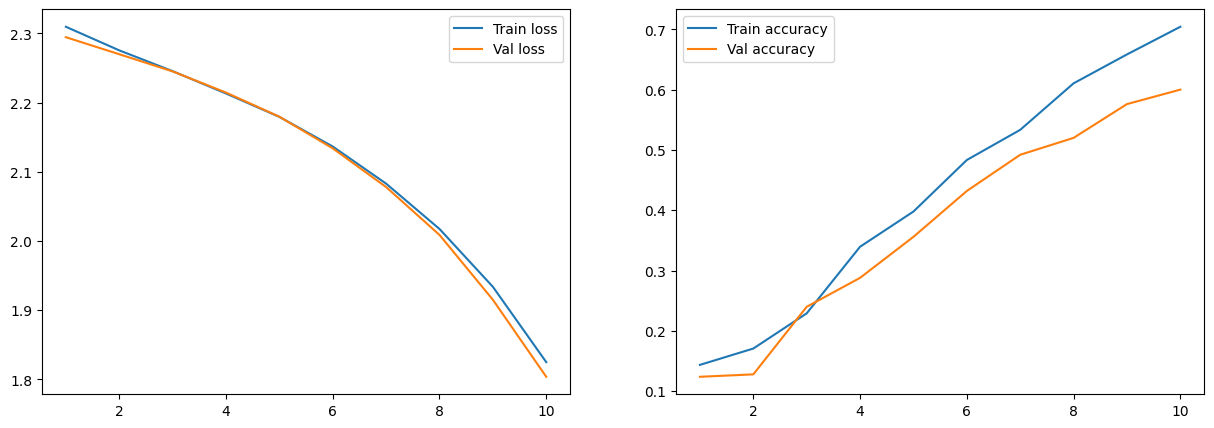

In [7]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot([h["epoch"] for h in history], [h["train_loss"] for h in history], label="Train loss")
plt.plot([h["epoch"] for h in history], [h["val_loss"] for h in history], label="Val loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot([h["epoch"] for h in history], [h["train_metrics"][0] for h in history], label="Train accuracy")
plt.plot([h["epoch"] for h in history], [h["val_metrics"][0] for h in history], label="Val accuracy")
plt.legend()
plt.show()